# Squares Data Set
May 5, 2025


## Summary

Image classification case study data includes 3 classes (A, B and C), already divided into train and validation sets (500 images for each class in each subset, total of 3000 images.) This notebook follows three main parts:

*   part 1: data exploration
*   part 2: train and evaluate models
*   part 3: compare models


### 1: Data Exploration

Getting familiarized with different aspects of the provided dataset - from file extensions, to sizes and colors. A quick study shows that each image file consists of a single colored square centered in a white background. Key findings include:
*   File extensions (.jpg, .png, .bmp) are roughly evenly distributed across classes.
*   Overall image dimensions vary but follow a similar distribution across classes.
*   Features like width of the inner square and its ratio to the image width were also examined but showed little difference accross different classes.
*   The primary differentiator appears to be the color of the central square: Class A is generally darker, Class B more saturated, and Class C lighter. This was visualized using a 3D RGB scatter plot which showed distinct clusters. I also created a box graph of euclydian distance of each color from 0,0,0 (= the color black).


### 2: Train and Evaluate Different Models

Based on data exploration, core signal seems to be color rather than complex spatial patterns. The modeling approach proceeded iteratively:
1.  **Baseline CNN:** A shallow CNN model (one Conv2d layer, one MaxPool2d, one Linear layer) was trained using standard `Resize` preprocessing as a baseline. This achieved moderate success (~84% validation accuracy, and ~82% train accuracy).
2.  **Color-Based Model (KNN):** Leveraging the color separation observed in step 1, a non-vision model was tested. K-Nearest Neighbors (k=5) classifier using only the normalized RGB values of the center pixel achieved excellent performance (~98.4% validation accuracy), significantly outperformed the baseline CNN. Similar high performance would be expected from other models like SVM or tree-based models, using the same RGB features. (future task: train a tree based model with rgb, image size, and size of inner square)
3.  **Improved CNN:** a second CNN was trained to test if we can achieve comparable performance to the KNN model. Key changes involved:
    *   **Preprocessing:** used `CenterCrop` based on the minimum observed inner square size, followed by `Resize` to 32x32. This focuses the CNN on the relevant colored area.
    *   **Architecture:** Using a slightly deeper structure (2 x Conv2d, 2 x MaxPool2d) to allow for potentially more hierarchical feature learning.
    This second CNN performed significantly better than the baseline (~98.3% validation accuracy), achieving results on par with the KNN model.


### 3: Compare Models

Comparing the models using overall accuracy and per-class metrics confirms the effectiveness of leveraging the core color feature.

*   The **baseline CNN** struggled relatively, especially with Class B recall, likely because the generic resizing diluted the essential color signal with the white background.
*   The **KNN model** achieved the highest overall accuracy, demonstrating the power of a simple approach when the core feature is well-understood and isolated.
*   The **improved CNN** effectively matched the KNN performance by incorporating the preprocessing insight gained from data exploration and KNN steps. Its slightly deeper architecture successfully learned the color distinctions once provided with the focused input.

This highlights that for this specific dataset, successful modeling hinges on identifying and appropriately utilizing the dominant color feature, either directly (KNN) or through targeted preprocessing for more complex models (CNN with `CenterCrop`).

**Performance Metrics Summary (Validation Set):**

| Model        | Overall Acc (%)| A:Precision| A: Recall| A: F1   | B:Precision| B:Recall | B:F1    | C:Precision| C:Recall |C: F1    |
|--------------|----------------|-----------|-----------|---------|-----------|-----------|---------|-----------|-----------|---------|
| basicCNN     | 84.13          | 0.85      | 0.86      | 0.86    | 0.81      | 0.71      | 0.76    | 0.86      | 0.96      | 0.90    |
| secondCNN    | 98.27          | 0.97      | 0.99      | 0.98    | 0.98      | 0.96      | 0.97    | 0.99      | 1.00      | 0.99    |
| KNN          | 98.40          | 0.97      | 0.99      | 0.98    | 0.99      | 0.96      | 0.98    | 0.99      | 1.00      | 0.99    |

.

<img src="img/metrics.png" alt="Model Performance Metrics Comparison"  width="80.75%">

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

np.random.seed(42)
torch.manual_seed(42)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
class_names = ['a', 'b', 'c']
train_dir = 'data/train'
val_dir = 'data/val'

### Data Exploration

In [3]:
# check file extensension, and sizes
train_ext = set()
val_ext = set()

for class_name in class_names:
    folder_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(folder_path)]
    train_ext.update([os.path.splitext(f)[1] for f in image_files])
    folder_path = os.path.join(val_dir, class_name)
    image_files = [f for f in os.listdir(folder_path)]
    val_ext.update([os.path.splitext(f)[1] for f in image_files])
print('Train extensions:', train_ext)
print('Val extensions:', val_ext)

Train extensions: {'.jpg', '', '.bmp', '.png'}
Val extensions: {'.jpg', '.bmp', '.png'}


In [4]:
# the empty ext name in train_ext is probably from .DS_Store
# we can treat the rest of the extensions as 'valid externsions' to surpass any filetype errors.
val_ext.update(train_ext)
valid_extensions = [e for e in val_ext if e != '']
valid_extensions

['.bmp', '.png', '.jpg']

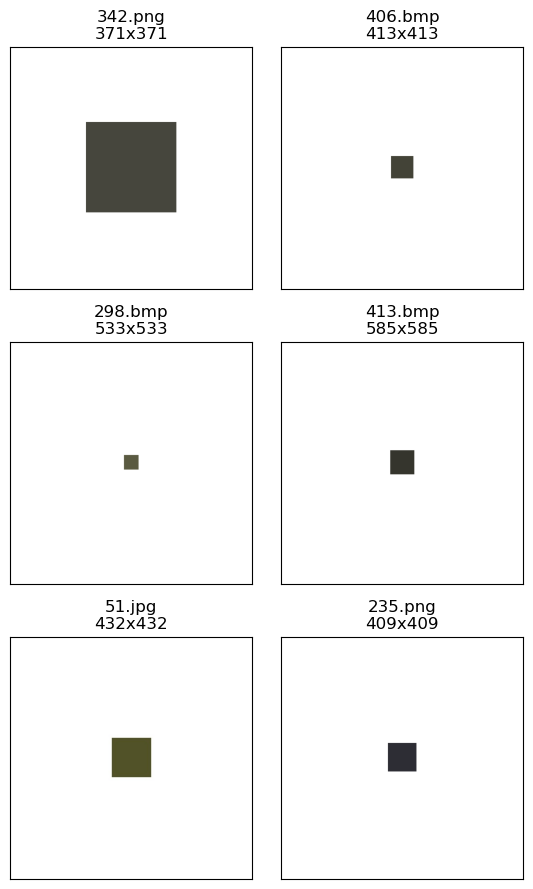

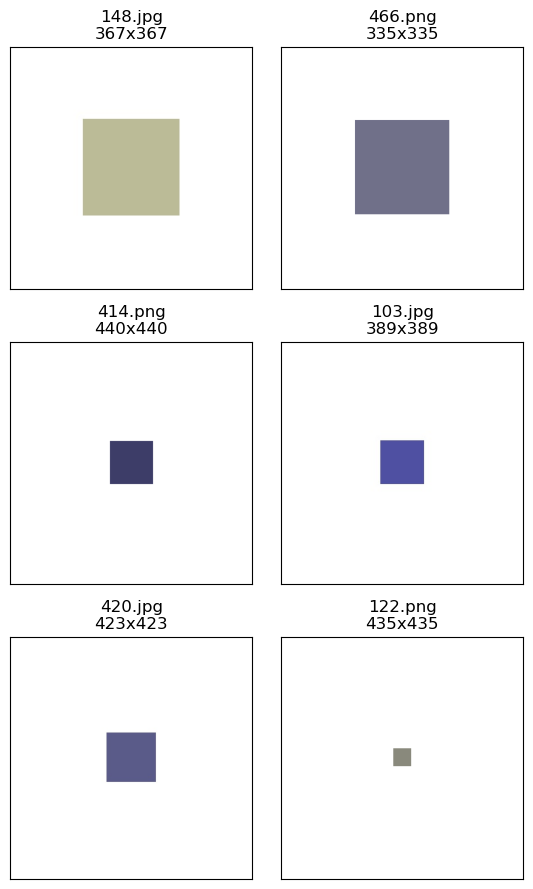

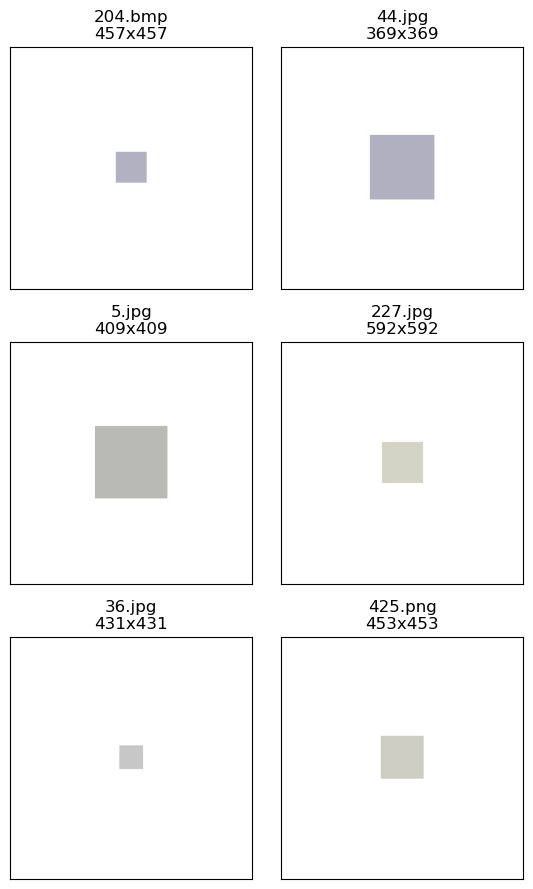

In [5]:
# check some sample images
num_samples_col = 2
num_samples_row = 3

for class_name in class_names:
    folder_path = os.path.join('data', 'train', class_name)
    image_files = [f for f in os.listdir(folder_path) if any(f.endswith(ext) for ext in valid_extensions)]
    selected_images = random.sample(image_files, num_samples_row * num_samples_col)
    plt.figure(figsize=(3 * num_samples_col, 3 * num_samples_row))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        plt.subplot( num_samples_row, num_samples_col, i+1)
        plt.imshow(np.array(img))
        width, height = img.size
        plt.tight_layout()
        plt.title(f"{os.path.basename(img_file)}\n{width}x{height}")
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.show()

right of the bat, it seems obvious that there is an easy semanitc difference between the 3 classes. 
class a looks darker than the rest, 
class b looks more saturated,
class c looks lighter in color.

before testing the vision models, I'll create a classification based on rgba values of the cenetr pixel from these images. There is a mix of different image file types, so we may have to do some work with color values to make them uniform.

Since all the color values are the same format (RGB, 0-255) there's no need for further data wrangling in that department.

In [6]:
# create separate train and val dataframes. 

train_df = pd.DataFrame(columns=['class', 'filename', 'width', 'height', 'r', 'g', 'b', 'inner_width'])
val_df = pd.DataFrame(columns=['class', 'filename', 'width', 'height', 'r', 'g', 'b', 'inner_width'])

train_folder_path = os.path.join('data', 'train')
val_folder_path = os.path.join('data', 'val')

for class_name in ['a', 'b', 'c']:
    for subset in ['train', 'val']:
        folder_path = os.path.join('data', subset, class_name)
        image_files = [f for f in os.listdir(folder_path) if any(f.endswith(ext) for ext in valid_extensions)]
        for i, img_file in enumerate(image_files):
            img_path = os.path.join(folder_path, img_file)
            img = Image.open(img_path)
            width, height = img.size
            r, g, b = [x/255 for x in img.getpixel((width//2, height//2))]
            inner_width = len([x for x in [img.getpixel((width//2, i)) for i in range(height)] if x!=(255, 255, 255)])
            row = {
                'class': class_name,
                'filename': img_file,
                'width': width,
                'height': height,
                'r': r, 
                'g': g,
                'b': b,
                'inner_width': inner_width
            }
            if subset == 'train':
                train_df.loc[len(train_df)] = row
            else:
                val_df.loc[len(val_df)] = row

train_df.to_csv('data/train.csv', index=False)
val_df.to_csv('data/val.csv', index=False)

In [7]:
display(train_df.sample(5), train_df.shape, val_df.sample(5), val_df.shape)

,class,filename,width,height,r,g,b,inner_width
1116,c,14.jpg,456,456,0.898039,0.894118,0.705882,44
1368,c,95.jpg,605,605,0.690196,0.694118,0.713725,80
422,a,68.png,449,449,0.278431,0.278431,0.282353,52
413,a,197.png,338,338,0.164706,0.164706,0.231373,42
451,a,15.bmp,389,389,0.313725,0.313725,0.262745,28


(1500, 8)

,class,filename,width,height,r,g,b,inner_width
479,a,224.png,496,496,0.113725,0.113725,0.258824,104
722,b,155.bmp,458,458,0.349020,0.349020,0.482353,78
1034,c,326.bmp,602,602,0.905882,0.905882,0.701961,72
1311,c,163.bmp,341,341,0.807843,0.807843,0.741176,90
670,b,260.png,600,600,0.486275,0.486275,0.505882,114


(1500, 8)

In [8]:
colors = {}
for c in class_names:
    colors[c] = train_df[train_df['class'] == c].sample()[['r', 'g', 'b']].values[0]

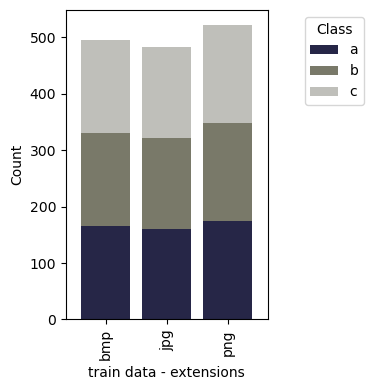

In [9]:
# stacked bar chart to show extensions 
plt.figure(figsize=(4, 4))

train_df['extensions'] = train_df['filename'].apply(lambda x: x.split('.')[1])
ext_counts_per_class = train_df[['class', 'extensions']].groupby(['class', 'extensions']).value_counts().reset_index()
pivoted_data = ext_counts_per_class.pivot(index='extensions', columns='class', values='count')

pivoted_data.plot(kind='bar', 
                  stacked=True, 
                  ax=plt.gca(), 
                  color=[colors[c] for c in class_names], 
                  legend=True, width=0.8)

plt.xlabel('train data - extensions')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper left', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

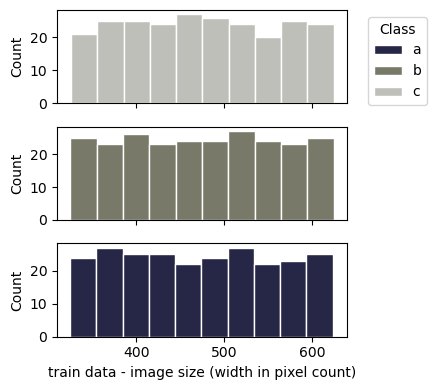

In [10]:
fig, axs = plt.subplots( nrows = 3, ncols = 1, figsize=(4.5, 4), sharex=True)

size_by_class = train_df[['class', 
                    'width']].groupby(['class', 
                                        'width']).value_counts().reset_index()

for i, c in enumerate(class_names[::-1]):
    g = sns.histplot(
        data=size_by_class[size_by_class['class'] == c],
        x='width',
        hue='class',
        bins=10,
        palette=colors,
        hue_order=class_names,
        alpha=1,
        edgecolor='white',
        ax = axs[i]
    )
    if i == 0:
        l = g.get_legend()
        l.set_bbox_to_anchor((1.05, 1))
        l.set_title('Class')
    else:
        g.get_legend().remove()

plt.xlabel('train data - image size (width in pixel count)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

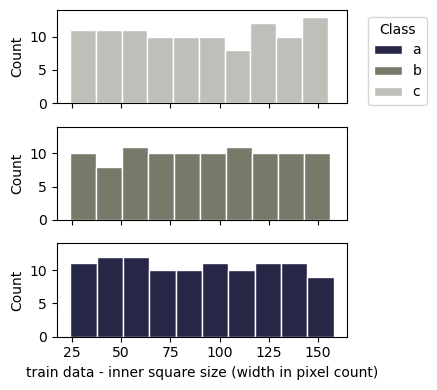

In [11]:
fig, axs = plt.subplots( nrows = 3, ncols = 1, figsize=(4.5, 4), sharex=True)

inner_width_by_class = train_df[['class', 
                    'inner_width']].groupby(['class', 
                                        'inner_width']).value_counts().reset_index()

for i, c in enumerate(class_names[::-1]):
    g = sns.histplot(
        data=inner_width_by_class[inner_width_by_class['class'] == c],
        x='inner_width',
        hue='class',
        bins=10,
        palette=colors,
        hue_order=class_names,
        alpha=1,
        edgecolor='white',
        ax = axs[i]
    )
    g.set_ylim(0, 14)
    if i == 0:
        l = g.get_legend()
        l.set_bbox_to_anchor((1.05, 1))
        l.set_title('Class')
    else:
        g.get_legend().remove()

plt.xlabel('train data - inner square size (width in pixel count)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

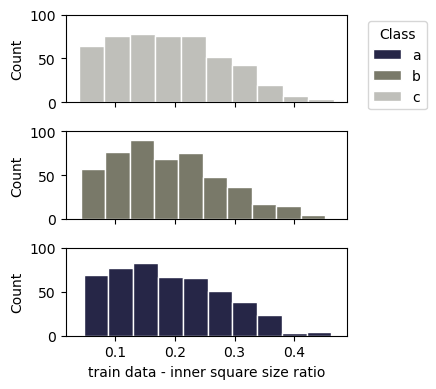

In [12]:
fig, axs = plt.subplots( nrows = 3, ncols = 1, figsize=(4.5, 4), sharex=True)

train_df['inner_ratio'] = train_df['inner_width'] / train_df['width']
inner_ratio_by_class = train_df[['class', 
                    'inner_ratio']].groupby(['class', 
                                        'inner_ratio']).value_counts().reset_index()

for i, c in enumerate(class_names[::-1]):
    g = sns.histplot(
        data=inner_ratio_by_class[inner_ratio_by_class['class'] == c],
        x='inner_ratio',
        hue='class',
        bins=10,
        palette=colors,
        hue_order=class_names,
        alpha=1,
        edgecolor='white',
        ax = axs[i]
    )
    g.set_ylim(0, 100)
    if i == 0:
        l = g.get_legend()
        l.set_bbox_to_anchor((1.05, 1))
        l.set_title('Class')
    else:
        g.get_legend().remove()

plt.xlabel('train data - inner square size ratio')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

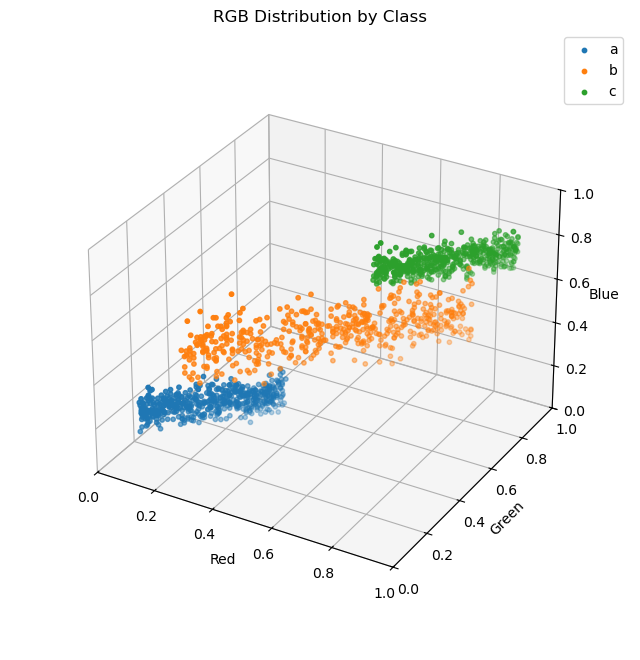

In [13]:
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d', )

# n = 500

for c in class_names:
    plot_df = train_df[train_df['class'] == c]
    # plot_df = plot_df.sample(n)
    ax.scatter(plot_df['r'], 
               plot_df['g'], 
               plot_df['b'], 
               marker= 'o', 
               label=c, 
               s = 10, 
            #    color=colors[c]
               )

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('RGB Distribution by Class')
ax.set_box_aspect(None, zoom=0.85)
ax.legend()
plt.show()

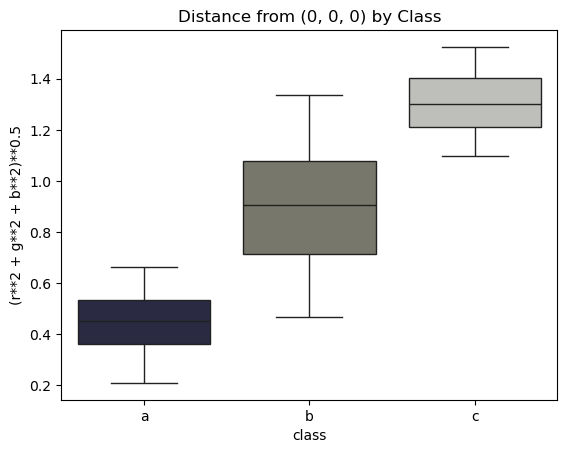

In [14]:
train_df['dist'] = train_df['r']**2 + train_df['g']**2 + train_df['b']**2
train_df['dist'] = train_df['dist'].apply(lambda x: x**0.5)

f = sns.boxplot(data=train_df,
            x='class',
            y='dist',
            hue='class',
            palette=colors,
            order=class_names,
            showfliers=False)
f.set_title('Distance from (0, 0, 0) by Class')
plt.ylabel('(r**2 + g**2 + b**2)**0.5');

## Train Models

In [15]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                if any(img_name.endswith(ext) for ext in valid_extensions):
                    img_path = os.path.join(class_dir, img_name)
                    if os.path.isfile(img_path):
                        self.samples.append((img_path, self.class_to_idx[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

combined_metrics = pd.DataFrame(columns=['model_name', 'class', 'accuracy', 'precision', 'recall', 'f1'])

def eval_torch_model(model, dataset, device = 'cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    if dataset == 'train':
        data_loader = train_loader
    else:
        data_loader = val_loader

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(4, 3.5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmax = 500, 
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Truth labels')
    plt.title(f'{dataset} data')
    plt.tight_layout()
    plt.show()

    return cm

### train basicCNN model as baseline

In [16]:
# Basic model
class basicCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # Just 8 filters
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(8 * 16 * 16, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
num_epochs = 10

transform = transforms.Compose([transforms.Resize((32, 32)), 
                                transforms.ToTensor()])

train_dataset = ImageDataset(train_dir, transform)
val_dataset = ImageDataset(val_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cpu")
first_cnn_model = basicCNN(len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(first_cnn_model.parameters(), lr=0.001)

# Train
for epoch in range(num_epochs):
    first_cnn_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = first_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Quick validation
    first_cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = first_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

torch.save(first_cnn_model.state_dict(), 'img_classifier.pth')

Epoch 1, Accuracy: 50.53%
Epoch 2, Accuracy: 64.27%
Epoch 3, Accuracy: 59.93%
Epoch 4, Accuracy: 61.47%
Epoch 5, Accuracy: 72.20%
Epoch 6, Accuracy: 69.20%
Epoch 7, Accuracy: 75.67%
Epoch 8, Accuracy: 79.40%
Epoch 9, Accuracy: 80.47%
Epoch 10, Accuracy: 84.13%


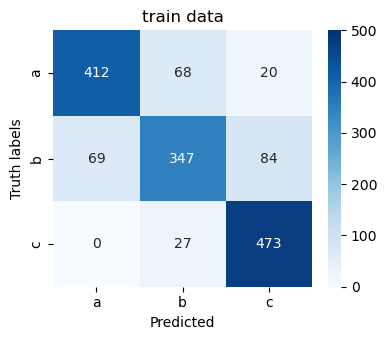

In [18]:
# evaluation
train_cm = eval_torch_model(first_cnn_model, 'train', device)

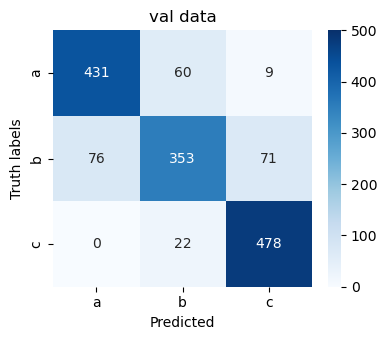

Class a:
  Precision: 0.85
  Recall: 0.86
  F1 Score: 0.86
Class b:
  Precision: 0.81
  Recall: 0.71
  F1 Score: 0.76
Class c:
  Precision: 0.86
  Recall: 0.96
  F1 Score: 0.90


In [19]:
val_cm = eval_torch_model(first_cnn_model, 'val', device)

for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'basicCNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

### train improved CNN model 

In [20]:
# second try
class secondCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 8 * 8, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 32 * 8 * 8)
        x = self.classifier(x)
        return x

In [21]:
num_epochs = 10

min_inner = train_df['inner_width'].min()
transform = transforms.Compose([transforms.CenterCrop((min_inner)),
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()])

train_dataset = ImageDataset(train_dir, transform)
val_dataset = ImageDataset(val_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

device = torch.device("cpu")
second_cnn_model = secondCNN(len(train_dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(second_cnn_model.parameters(), lr=0.001)

# Train
for epoch in range(num_epochs):
    second_cnn_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = second_cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Quick validation
    second_cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = second_cnn_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Epoch {epoch+1}, Accuracy: {100 * correct / total:.2f}%')

torch.save(second_cnn_model.state_dict(), 'img_classifier_center_crop.pth')

Epoch 1, Accuracy: 93.53%
Epoch 2, Accuracy: 98.40%
Epoch 3, Accuracy: 97.20%
Epoch 4, Accuracy: 98.53%
Epoch 5, Accuracy: 96.13%
Epoch 6, Accuracy: 97.80%
Epoch 7, Accuracy: 98.53%
Epoch 8, Accuracy: 98.47%
Epoch 9, Accuracy: 98.33%
Epoch 10, Accuracy: 98.27%


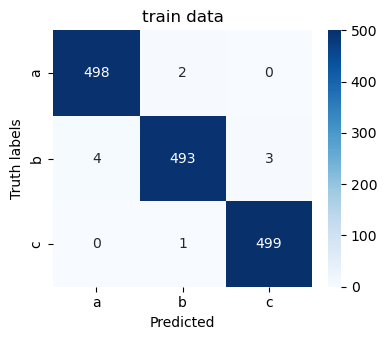

In [22]:
train_cm = eval_torch_model(second_cnn_model, 'train', device)

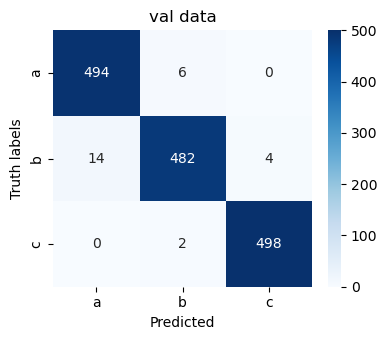

Class a:
  Precision: 0.97
  Recall: 0.99
  F1 Score: 0.98
Class b:
  Precision: 0.98
  Recall: 0.96
  F1 Score: 0.97
Class c:
  Precision: 0.99
  Recall: 1.00
  F1 Score: 0.99


In [23]:
val_cm = eval_torch_model(second_cnn_model, 'val', device)

for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'secondCNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

### train a KNN model

Accuracy: 98.40%


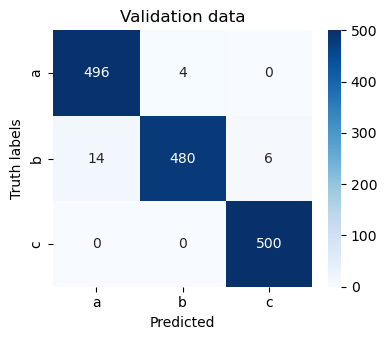

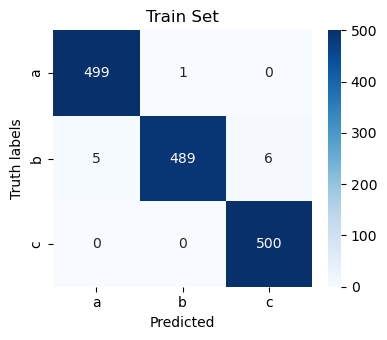

In [24]:
X_train = train_df[['r', 'g', 'b']].values  # Using raw RGB values
y_train = train_df['class'].values

X_val = val_df[['r', 'g', 'b']].values
y_val = val_df['class'].values

X_train_scaled = X_train
X_val_scaled = X_val

k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_val_scaled)

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {100 * accuracy:.2f}%")

classes = np.unique(y_train)
val_cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(4, 3.5))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Truth labels')
plt.title('Validation data')
plt.tight_layout()
plt.show()

train_cm = confusion_matrix(y_train, knn.predict(X_train_scaled))
plt.figure(figsize=(4, 3.5))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Truth labels')
plt.title('Train Set')
plt.tight_layout()
plt.show()

In [25]:
for c in class_names:
    tp = val_cm[class_names.index(c)][class_names.index(c)]
    fn = sum(val_cm[class_names.index(c)]) - tp
    fp = sum(val_cm[:, class_names.index(c)]) - tp
    tn = sum(sum(val_cm)) - tp - fn - fp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    print(f"Class {c}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1_score:.2f}")
    combined_metrics.loc[len(combined_metrics)] = {
        'model_name': 'KNN',
        'class': c,
        'accuracy': 100 * correct / total,
        'precision': precision,
        'recall': recall,
        'f1': f1_score
    }

Class a:
  Precision: 0.97
  Recall: 0.99
  F1 Score: 0.98
Class b:
  Precision: 0.99
  Recall: 0.96
  F1 Score: 0.98
Class c:
  Precision: 0.99
  Recall: 1.00
  F1 Score: 0.99


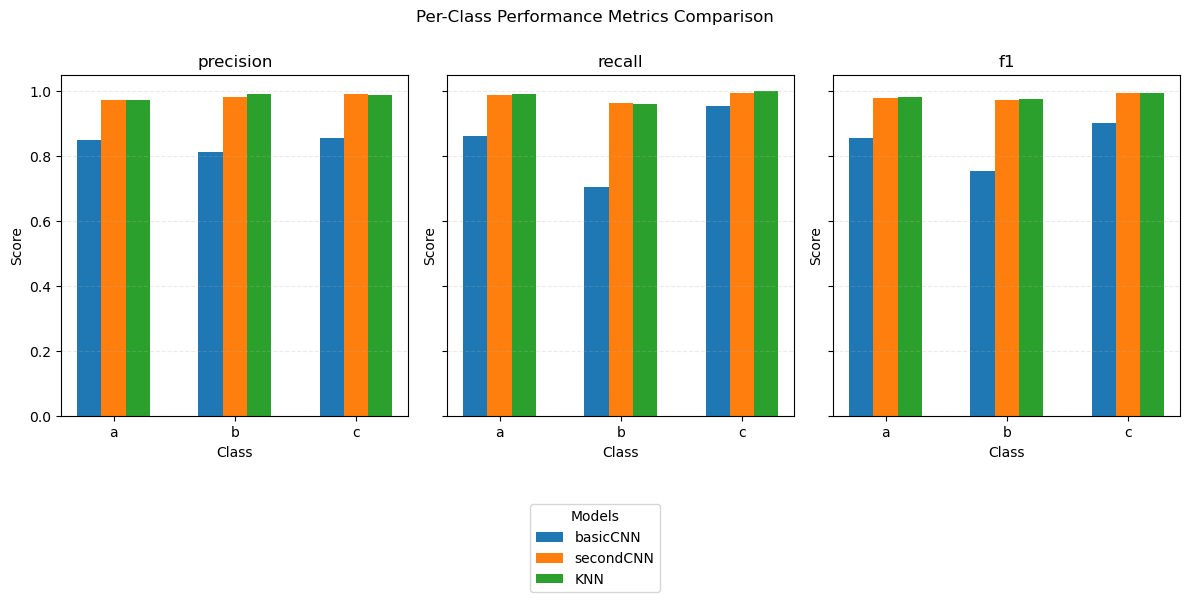

In [26]:
num_classes = combined_metrics['class'].nunique()
num_models = combined_metrics['model_name'].nunique()
metrics = ['precision', 'recall', 'f1']

x = np.arange(num_classes)
bar_width = 0.20

fig, axes = plt.subplots(1, num_models, figsize=(12, 5), sharey=True)
fig.suptitle('Per-Class Performance Metrics Comparison')

for i in range(len(metrics)):
    ax = axes[i]
    metric_name = metrics[i]

    for j, model in enumerate(combined_metrics['model_name'].unique()):
        model_name = combined_metrics['model_name'].unique()[j]
        positions = x + (j - (num_models - 1) / 2) * bar_width
        scores = combined_metrics[combined_metrics['model_name'] == model_name][metric_name]
        rects = ax.bar(positions, scores, bar_width, label=model_name if i == 0 else "")

    ax.set_ylabel('Score')
    ax.set_xlabel('Class')
    ax.set_title(metric_name)
    ax.set_xticks(x)
    ax.set_xticklabels(classes) 
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='--', alpha=0.25)
  


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.005), ncol=1, title="Models")

plt.tight_layout(rect=[0, 0.05, 1, 0.98])
plt.show()